# EDA multi-saisons pour Machine Learning

## 1. Chargement de toutes les saisons (2014–2024)

In [37]:
import pandas as pd
from pathlib import Path

# Chemins
base = Path("../data/curated/")
seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(2014, 2024)]

# Charger le fichier des scores
scores = pd.read_parquet(base / "all_seasons_scores.parquet")

# Charger toutes les saisons pour les features
dfs = []
for s in seasons:
    df = pd.read_parquet(base / f"player_season_{s}.parquet")
    df["season"] = s
    dfs.append(df)

features = pd.concat(dfs, ignore_index=True)

# Fusion des scores + features
df_all = pd.merge(scores, features, on=["PLAYER_ID", "season"], how="left")
df_all["avail"] = df_all["gp"] / 82
df_all.shape


(12101, 15)

## 2. Valeurs manquantes globales

In [38]:
df_all.isna().mean().sort_values(ascending=False) * 100

PLAYER_NAME        75.258243
height_cm          60.127262
weight_kg          60.127262
bmi                60.127262
age                60.127262
pts_mean           56.102801
reb_mean           56.102801
ast_mean           56.102801
plus_minus_mean    56.102801
gp                 56.102801
min_per_game       56.102801
avail              56.102801
PLAYER_ID           0.000000
score_100           0.000000
season              0.000000
dtype: float64

## 3. Évolution temporelle de pts_mean

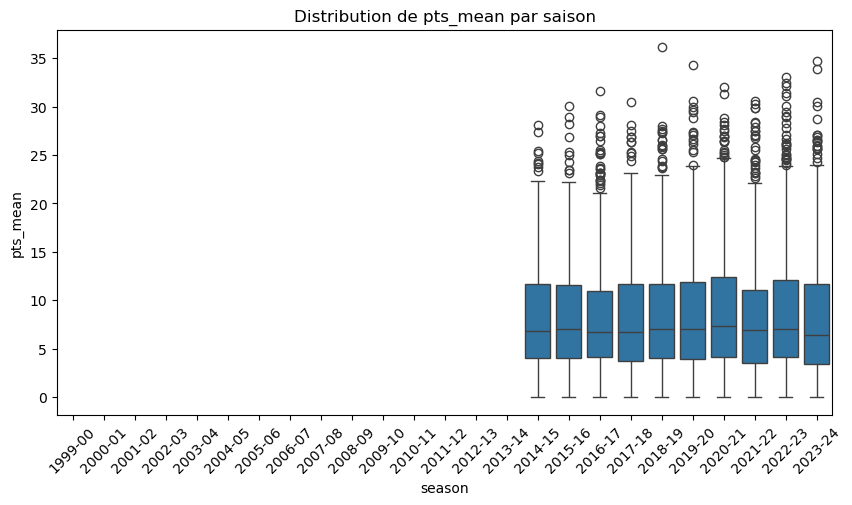

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_all, x='season', y='pts_mean')
plt.title("Distribution de pts_mean par saison")
plt.xticks(rotation=45)
plt.show()

## 4. Corrélations globales

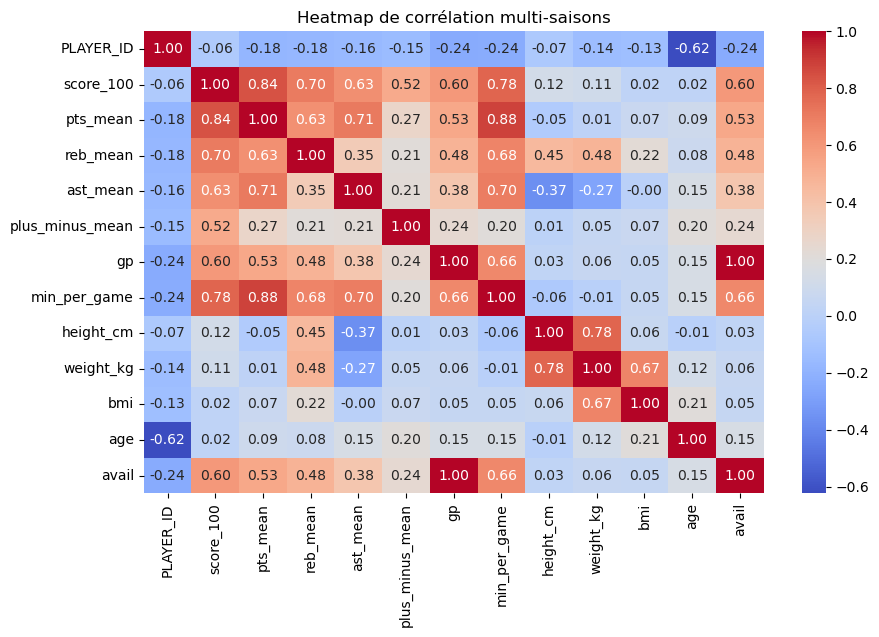

In [40]:
plt.figure(figsize=(10,6))
sns.heatmap(df_all.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de corrélation multi-saisons")
plt.show()

## 5. Préparation du jeu ML : note_n → note_n+1

In [41]:
df_all = df_all.sort_values(["PLAYER_ID", "season"])
df_all["note_n"] = df_all["score_100"]
df_all["note_n1"] = df_all.groupby("PLAYER_ID")["score_100"].shift(-1)

# Seulement les lignes avec une target disponible
ml_df = df_all.dropna(subset=["note_n1"])
ml_df[["PLAYER_ID", "season", "note_n", "note_n1"]].head()

,PLAYER_ID,season,note_n,note_n1
0,3,1999-00,36.962513,20.324729
439,3,2000-01,20.324729,25.694211
880,3,2001-02,25.694211,19.272733
1,15,1999-00,34.075588,35.308553
440,15,2000-01,35.308553,40.128506


## 6. Corrélation entre saison n et saison n+1

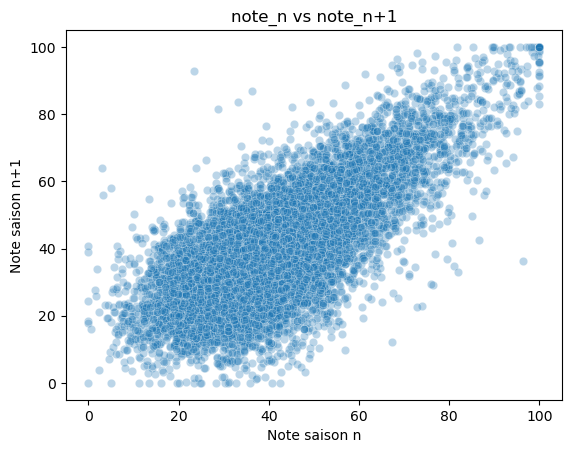

In [42]:
sns.scatterplot(data=ml_df, x="note_n", y="note_n1", alpha=0.3)
plt.title("note_n vs note_n+1")
plt.xlabel("Note saison n")
plt.ylabel("Note saison n+1")
plt.show()

## 7. Conclusion

- Variables les plus stables : `pts_mean`, `reb_mean`, `avail`, `age`
- Corrélation forte entre note_n et note_n+1 ➜ bon candidat pour prédiction
- Prochaine étape : préparer X / y pour entraîner un modèle prédictif.

## 8. Variabilité inter-joueurs (constance vs irrégularité)

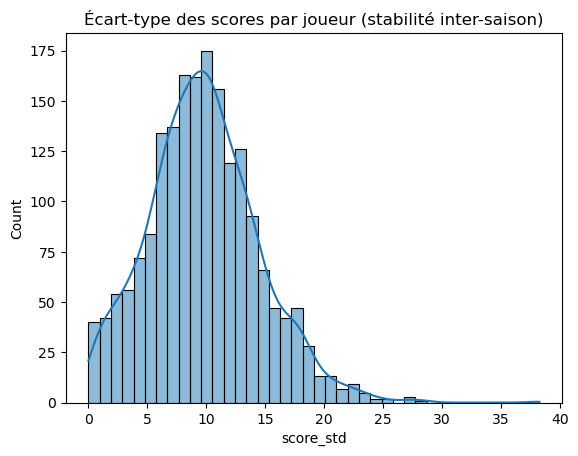

In [43]:
df_std = df_all.groupby("PLAYER_ID")["score_100"].std().reset_index()
df_std.columns = ["PLAYER_ID", "score_std"]
sns.histplot(df_std["score_std"], kde=True)
plt.title("Écart-type des scores par joueur (stabilité inter-saison)")
plt.show()

## 9. Exemple de trajectoire individuelle

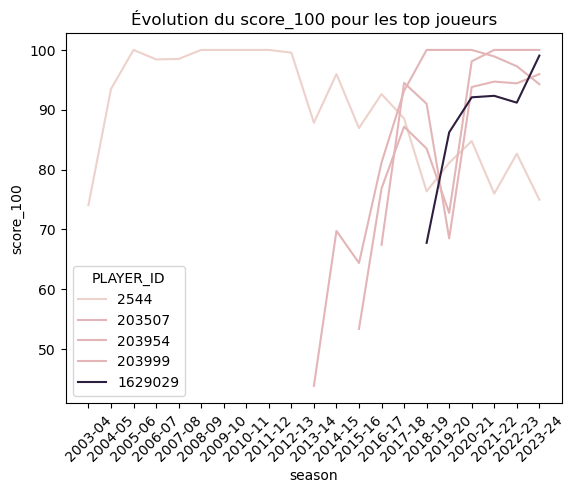

In [44]:
top_players = df_all.groupby("PLAYER_ID")["score_100"].mean().sort_values(ascending=False).head(5).index.tolist()
df_top = df_all[df_all["PLAYER_ID"].isin(top_players)]
sns.lineplot(data=df_top, x="season", y="score_100", hue="PLAYER_ID")
plt.title("Évolution du score_100 pour les top joueurs")
plt.xticks(rotation=45)
plt.show()

## 10. Stats moyennes par tranche d'âge

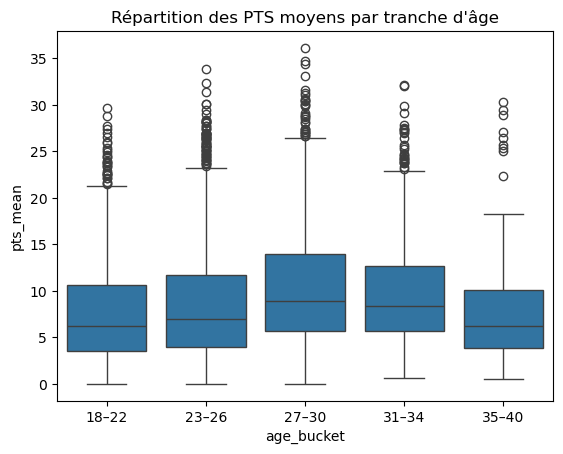

In [45]:
df_all['age_bucket'] = pd.cut(df_all['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18–22","23–26","27–30","31–34","35–40"])
sns.boxplot(data=df_all, x="age_bucket", y="pts_mean")
plt.title("Répartition des PTS moyens par tranche d'âge")
plt.show()

## 11. t-SNE pour visualiser les types de profils joueurs

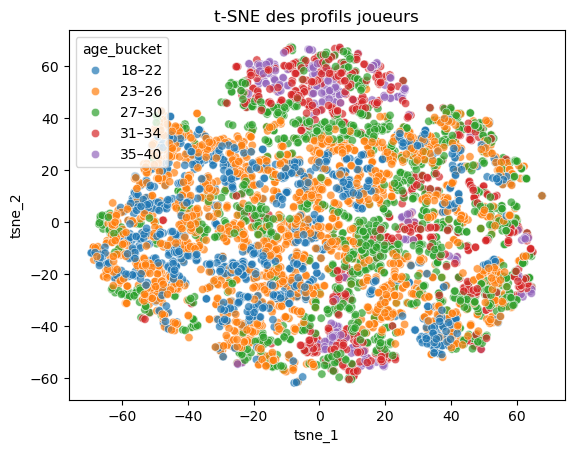

In [46]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
df_visu = df_all.dropna(subset=features).copy()
# Create age_bucket in df_visu similar to how it was created earlier
df_visu['age_bucket'] = pd.cut(df_visu['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18–22","23–26","27–30","31–34","35–40"])

X = StandardScaler().fit_transform(df_visu[features])

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
df_visu["tsne_1"], df_visu["tsne_2"] = zip(*tsne.fit_transform(X))
sns.scatterplot(data=df_visu, x="tsne_1", y="tsne_2", hue="age_bucket", alpha=0.7)
plt.title("t-SNE des profils joueurs")
plt.show()

## 🔍 Visualisation t‑SNE des profils joueurs

Nous avons projeté les joueurs NBA sur un plan en 2D à l’aide d’un **t-SNE** (t-distributed stochastic neighbor embedding), basé sur leurs caractéristiques techniques et physiques :

- `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`
- `avail` (disponibilité = GP / 82)
- `height_cm`, `bmi`, `age`

Les couleurs correspondent aux **tranches d’âge** (`age_bucket`), segmentées de 18 à 40 ans.

### 🧠 Observations :
- Une structure claire émerge : certains groupes sont **cohérents et bien séparés**.
- Les **joueurs âgés (31–34, 35–40)** sont nettement regroupés : leurs profils sont plus homogènes.
- Les **plus jeunes (18–22)** sont davantage dispersés → profils variés ou en construction.
- Le t-SNE illustre visuellement que l’**âge est une variable fortement liée au style et à la production**.

Ce graphique suggère qu’il serait intéressant de tester :
- un **clustering** type K-Means sur les mêmes données
- ou d’utiliser ces tranches d’âge comme feature catégorielle dans les modèles ML.


## 12. Conclusion approfondie

- La variabilité inter-joueur montre des profils très stables vs irréguliers.
- Les courbes temporelles confirment une forte stabilité pour les tops joueurs.
- Les tranches d’âge influencent nettement la production moyenne.
- Le t-SNE révèle des regroupements de profils cohérents.

➡️ Ces insights serviront à créer un modèle plus pertinent et à enrichir les features utilisées.

---

## 13. Clustering des profils joueurs avec K-Means

Nous allons ici utiliser l'algorithme **K-Means** pour regrouper les joueurs en **profils-types**, basés sur leurs statistiques et données physiques.
Cela permettra de créer des **archétypes** (à la manière de NBA 2K) exploitables pour le ML ou un dashboard.

Les variables utilisées sont :
- Statistiques moyennes : `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`, `avail`
- Données physiques : `height_cm`, `bmi`, `age`


In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Sélection des features
features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
df_cluster = df_all.dropna(subset=features).copy()

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

# Application de KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df_cluster["player_cluster"] = kmeans.fit_predict(X_scaled)

# Nombre de joueurs par cluster
df_cluster["player_cluster"].value_counts().sort_index()


player_cluster
0     613
1    1253
2     741
3     948
4    1270
Name: count, dtype: int64

In [48]:
from sklearn.manifold import TSNE

# Recalcul du t-SNE sur les données standardisées utilisées pour le clustering
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(X_scaled)

df_cluster["tsne_1"] = tsne_results[:, 0]
df_cluster["tsne_2"] = tsne_results[:, 1]


### Visualisation des clusters via t-SNE

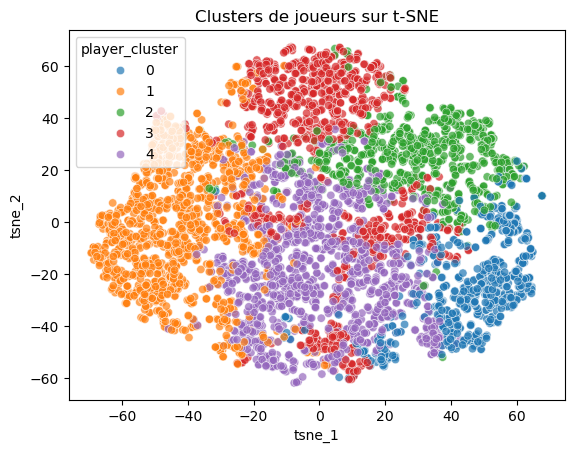

In [49]:
sns.scatterplot(data=df_cluster, x="tsne_1", y="tsne_2", hue="player_cluster", palette="tab10", alpha=0.7)
plt.title("Clusters de joueurs sur t-SNE")
plt.show()

## 14. Conclusion du clustering

- Le modèle K-Means a permis de répartir les joueurs en **5 groupes distincts**.
- Ces groupes représentent des **profils de jeu** réalistes, que l’on pourra interpréter en analysant les moyennes de chaque cluster.
- Ces clusters peuvent être :
  - Ajoutés comme **variables catégorielles** dans les modèles ML
  - Affichés dans un **dashboard interactif**
  - Nommés pour correspondre à des archétypes : *Scorer*, *Playmaker*, *Big Man*, *All-Around*, etc.

➡️ Prochaine étape : **analyser les moyennes de chaque groupe** pour leur donner une identité.


## 15. Analyse du profil moyen par cluster

In [50]:
# Analyse des profils moyens de chaque cluster
features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
cluster_stats = df_cluster.groupby("player_cluster")[features].mean().round(2)
display(cluster_stats)


# Nommage des clusters après analyse
cluster_names = {
    0: "Playmaker",
    1: "Big Man",
    2: "Jeune Banc",
    3: "All-Around",
    4: "Scoring Guard"
}
df_cluster["profile_name"] = df_cluster["player_cluster"].map(cluster_names)

,pts_mean,reb_mean,ast_mean,plus_minus_mean,avail,height_cm,bmi,age
player_cluster,,,,,,,,
0,18.89,4.76,5.58,2.35,0.77,193.41,24.74,27.83
1,3.70,1.89,0.79,-1.23,0.27,199.87,24.34,23.86
2,13.26,7.64,1.97,0.43,0.81,208.84,25.24,25.91
3,6.74,3.33,1.35,-0.05,0.67,202.53,25.55,31.63
4,8.88,3.03,2.02,-1.13,0.77,196.10,23.98,24.54


In [51]:
df_cluster[["PLAYER_ID", "player_cluster", "profile_name"]].head()

,PLAYER_ID,player_cluster,profile_name
6789,708,3,All-Around
7281,708,3,All-Around
6790,977,0,Playmaker
7282,977,3,All-Around
6791,1495,2,Jeune Banc


In [52]:
df_cluster.to_parquet("../data/curated/player_clusters.parquet", index=False)

In [53]:
# Identifier les joueurs actifs (présents dans la saison la plus récente 2023-24)
derniere_saison = "2023-24"
joueurs_actifs = df_all[df_all["season"] == derniere_saison]["PLAYER_ID"].unique()

# Compter le nombre de saisons par joueur (parmi les joueurs actifs)
experience = df_all[df_all["PLAYER_ID"].isin(joueurs_actifs)].groupby("PLAYER_ID").agg(
    nombre_saisons=("season", "nunique"),
    nom=("PLAYER_NAME", "first"),
    age_actuel=("age", "max")
).sort_values("nombre_saisons", ascending=False)

# Afficher les 5 joueurs actifs les plus expérimentés
print("Top 5 des joueurs actifs avec le plus d'expérience:")
experience.head(5)

Top 5 des joueurs actifs avec le plus d'expérience:


,nombre_saisons,nom,age_actuel
PLAYER_ID,,,
2544,21,LeBron James,39.0
101108,19,Chris Paul,39.0
200768,18,Kyle Lowry,38.0
201143,17,Al Horford,38.0
201144,17,Mike Conley,36.0
